# Resume Parsing

So basically, we want to create a entity ruler to parse real resume and get the "skills".

But for your assignment, i will ask you to extract education.

## 1. Load data

In [2]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("./data/resume.csv")

In [3]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]  #optional if your computer is fast, no need
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [4]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = "./data/skills.jsonl"

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [6]:
doc = nlp("Chaky loves deep learning.")
doc.ents

(Chaky, deep learning)

## 3. Let's try to extract skills from this resume.csv

In [7]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
2143,22754014,CONTENT STRATEGIST Summary ...,"<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS
1133,28951817,CONSULTANT Professional Summa...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT
124,85101052,TECHNICAL DESIGNER Career O...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER
549,19234823,FINANCE DIRECTOR Professional S...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE
1075,18171955,SALES MANAGER Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",SALES


In [8]:
from spacy.lang.en.stop_words import STOP_WORDS

#before that, let's clean our resume.csv dataframe
def preprocessing(sentence):
    
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

In [9]:
#let's try Chaky, if you feel too dangerous
#random sampling
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         ASSISTANT CHEF         Highlights        Microsoft Word, Excel, PowerPoint, and Access              Experience         May 2015   to   Current      Company Name   －   City  ,   State          Assistant Chef     Oct 2008   to   Nov 2011       Developed and prepared meals.  Coordinated with m'

In [10]:
preprocessing(random_resume[:300])

'assistant chef highlights microsoft word excel powerpoint access experience may 2015 current company name － city state assistant chef oct 2008 nov 2011 develop prepared meal coordinate m'

In [11]:
#let's apply to the whole dataframe
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [12]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
2143,22754014,CONTENT STRATEGIST Summary ...,"<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS,content strategist summary energetic persuasiv...
1133,28951817,CONSULTANT Professional Summa...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant professional summary health care ad...
124,85101052,TECHNICAL DESIGNER Career O...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,technical designer career overview ● have 8.5 ...
549,19234823,FINANCE DIRECTOR Professional S...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE,finance director professional summary to find ...
1075,18171955,SALES MANAGER Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sales manager highlights ms office proficiency...


## 4. Let's really extract skills!!

In [13]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    skills = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    
    return skills

def unique_skills(x):
    return list(set(x))

In [14]:
df_resume.head(1)

,ID,Resume_str,Resume_html,Category,Clean_resume
2143,22754014,CONTENT STRATEGIST Summary ...,"<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS,content strategist summary energetic persuasiv...


In [15]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [17]:
df_resume.Skills.iloc[0]

['medium',
 'design',
 'support',
 'graphic design',
 'advertising',
 'marketing',
 'content management',
 'software',
 'database',
 'project management',
 'search engine',
 'wireless',
 'twitter',
 'business']

## 5. Visualization

Which skills is most important in information management?

In [22]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [23]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(48, 6)

In [24]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [25]:
#counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [26]:
counting

OrderedDict([('software', 45),
             ('support', 44),
             ('design', 36),
             ('security', 34),
             ('business', 32),
             ('server', 32),
             ('database', 31),
             ('windows', 29),
             ('documentation', 20),
             ('project management', 19)])

<BarContainer object of 10 artists>

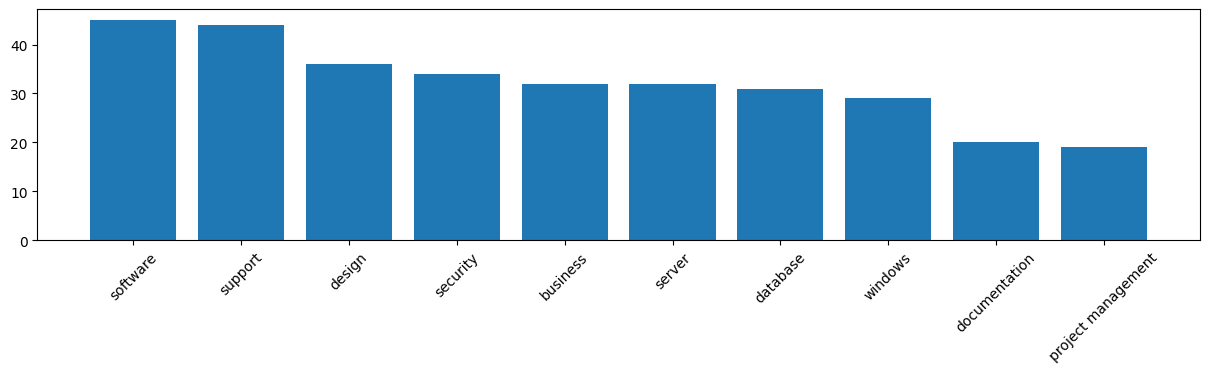

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [28]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[2]

In [29]:
doc = nlp(text)

In [30]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [31]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7fa3a03335e0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7fa3a03333a0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7fa3b757b920>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7fa39ffb3f00>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7fa39ffa8d40>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7fa3a0735fc0>),
 ('entity_ruler', <spacy.pipeline.entityruler.EntityRuler at 0x7fa3a0bf70c0>)]

In [32]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

## 7. Let's load the PDF - add some realism

In [60]:
from PyPDF2 import PdfReader
#pip install PyPDF2

reader = PdfReader("./data/someone_cv.pdf")
page = reader.pages[0] #first page just for demo
text = page.extract_text() 

In [48]:
text = preprocessing(text)

In [49]:
doc = nlp(text)

In [38]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [39]:
#last thing i go to assignment
#collect all the skill and put it into a list

skills = []

for ent in doc.ents:
    if ent.label_ == 'SKILL':
        skills.append(ent.text)
        
print(set(skills))

{'engineering', 'ai', 'deep learning', 'computer science', 'algorithms'}


## Let's try to extract education

In [40]:
# First, we need to have entity ruler similar to the one from the skill extraction.
# I tried to find from google but no avail, so I need to make one by myself TT.

from spacy.matcher import Matcher

# Let try to test.
pattern_education = [{"TEXT":"doctoral"}]
matcher = Matcher(nlp.vocab)
matcher.add("EDUCATION", [pattern_education])

doc = nlp("Post-doctoral Fellow, NSERC scholarship, Statistical \
learning / sequential data, Michael I. Jordan’s group, Brain \
and Cognitive Sciences Dept., MIT, Massachusetts.")

matches = matcher(doc)

for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)

12226150380531036764 EDUCATION 2 3 doctoral


In [41]:
# This seem to work, let try to add it into JsonL
doc[2:3]

doctoral

In [69]:
# The code above that Chaky uses only extract one page! but I want all the pages!

reader = PdfReader("./data/someone_cv.pdf")
n_page = len(reader.pages)
output = ''
for i in range(n_page):
    page = reader.pages[i]
    output += page.extract_text()

In [74]:
# Hmmm, very long
print(len(output))
text = preprocessing(output)
doc = nlp(text)


105153


In [75]:
# Let's try to use what we wrote above.

#pattern_education = [{"TEXT":"doctoral"}]
#matcher = Matcher(nlp.vocab)
#matcher.add("EDUCATION", [pattern_education])

matches = matcher(doc)

for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)

12226150380531036764 EDUCATION 1420 1421 doctoral
12226150380531036764 EDUCATION 1440 1441 doctoral


In [83]:
# Let's test the results.
# Hmmm, look good it's detect post-doctoral as doctoral because we did not add the post-doctoral rules yet!
print(doc[1415:1425])
print(doc[1435:1445])

studies diplomas 1992–1993 post - doctoral fellow learning vision algorithm
new jersey 1991–1992 post - doctoral fellow nserc scholarship statistical


In [90]:
print(doc[1460: 1475])

ph.d. computer science nserc scholarship neural networks markovian models computer science dept . mcgill


In [124]:
doc[1463]

science

In [92]:
# Let's try to use wildcard and fuzzy

pattern_education = [ 
    [{"TEXT":"doctoral"}, {"TEXT":"in"}, {}],
    [{"TEXT": {"FUZZY": "phd"}}, {"TEXT":"in"}, {}] # use fuzzy to find the word that are alikes... e.g. Tonson --> Tomson
]

matcher = Matcher(nlp.vocab)
matcher.add("EDUCATION", pattern_education)

matches = matcher(doc)

for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)

12226150380531036764 EDUCATION 4600 4603 pca in neural


In [94]:
# Now we know that fuzzy is not good, do not use it in this work
print(doc[4595:4608])

eigenfunction link spectral embedding kernel pca in neural computation 16.10 2004 p. 2197–2219


In [126]:
# Now we find a way to obtain educational levels, let's put in into jsonl and do the same of all degree
pattern_education = [ 
    [{"TEXT":"doctoral"}],
    [{"TEXT": "phd"}],
    [{"TEXT": "ph.d."}],
    [{"TEXT": "ph.d"}, {"IS_PUNCT": True}],
    [{"TEXT": "ph.d"}]
]

matcher = Matcher(nlp.vocab)
matcher.add("EDUCATION", pattern_education)

matches = matcher(doc)

for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)

12226150380531036764 EDUCATION 795 796 phd
12226150380531036764 EDUCATION 812 813 phd
12226150380531036764 EDUCATION 1420 1421 doctoral
12226150380531036764 EDUCATION 1440 1441 doctoral
12226150380531036764 EDUCATION 1460 1461 ph.d
12226150380531036764 EDUCATION 1460 1462 ph.d.
12226150380531036764 EDUCATION 1528 1529 phd


In [191]:
# Remove old entity ruler
ruler = nlp.remove_pipe("entity_ruler")

In [192]:
# Use the modified entity ruler
# This education file also contains skills
skill_path = "./data/education.jsonl"
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [193]:
doc = nlp("Tonson currently studying master degree in data science")
doc.ents

(Tonson, master, data science)

In [194]:
doc.ents[2].label_

'SKILL'

In [195]:
# Modify from get skills above
def get_education(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    education = []
    
    #look at the ents
    for idx, ent in enumerate(doc.ents):
        #if the ent.label_ is SKILL, then we append it together with education e.g. Master in Data science
        if ent.label_ == "EDUCATION":
            try: 
                if doc.ents[idx + 1].label_ == 'SKILL': # Check if the next word is skill
                    temp = ent.text + ' in ' + doc.ents[idx + 1].text # if it is combine them e.g. 'Master' +'in' + 'data science'
                    education.append(temp)
                else:
                    education.append(ent.text)
            except:
                education.append(ent.text)
    
    return education

In [196]:
df_resume['Education'] = df_resume.Clean_resume.apply(get_education)
df_resume['Education'] = df_resume.Education.apply(unique_skills)

In [197]:
# It's not work very well but still acceptable in this case.
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume,Skills,Education
2143,22754014,CONTENT STRATEGIST Summary ...,"<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS,content strategist summary energetic persuasiv...,"[medium, design, support, graphic design, adve...",[]
1133,28951817,CONSULTANT Professional Summa...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant professional summary health care ad...,"[data management, support, business intelligen...",[bachelor]
124,85101052,TECHNICAL DESIGNER Career O...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,technical designer career overview ● have 8.5 ...,"[testing, languages, eclipse, segment, server,...",[bachelor in engineering]
549,19234823,FINANCE DIRECTOR Professional S...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE,finance director professional summary to find ...,"[collaboration, engineering, financial system,...",[bachelor in business administration]
1075,18171955,SALES MANAGER Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sales manager highlights ms office proficiency...,"[support, design, network performance, play, b...",[bachelor in business administration]
